# Section 05
## Exercise 05.1
The mean distance from the nucleus $\langle r^\star \rangle$ of the hydrogen electron in configurations $(n,l,m) = (1,0,0)$ and $(n,l,m) = (2,1,0)$ will be estimated using Markov chain Monte Carlo methods to sample from the respective wavefunctions. Specifically the Metropolis-Hastings algorithm will be used, comparing uniform and gaussian step sampling strategies.\
All results are reported in Bohr radius units, as pointed out by the $\star$ symbol next to the variables.

In [1]:
# Defining exercise-specific variables and utilities
import subprocess as proc
from typing import List, Any, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing project specific variables and utilities, like the executable paths
from global_utils import *

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 130})

SECTION = "05"
EX = SECTION + "_1"

In [2]:
# Defining some constants
# A number of throws big enough to have ~10^6 unique point samples, accounting for ~50% step acceptance rate 
N_THROWS = 2_000_000
# The standard number of blocks
N_BLOCKS = 100
# A tentative value for the equilibration length
WARMUP_STEPS = 1_000
ORBITALS = ["s", "2p"]
TRANSITIONS = ["uniform", "gauss"]
# Stepping distributions parameters. For the uniform distributions this is
# the nonzero probability box's half-edge, for the gaussian distribution it is the standard deviation.
# These values are chosen to reach ~50% step acceptance rate.
TP = {
    "uniform": {"s": 1.22, "2p": 3.1},
    "gauss": {"s": 0.75, "2p": 2.0},
}


def data_dir(warmup_steps: int, s0: List[float]) -> Path:
    """Where measures using s0 as starting point get stored

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0 (List[float]): Starting point for the Markov chain. Must be a point in 3D space.
    
    Returns:
        pathlib.Path: The path to the measures file.
    """
    return results_dir(SECTION) / str(warmup_steps) / str(s0).strip("[]").replace(", ", "")


def read_positions(warmup_steps: int, s0: List[float], orbital: str, transition: str) -> pd.DataFrame:
    """Reads the csv file containing the positions sampled by the MCMC algorithm starting in s0
    using the "orbital" wavefunction and the "transition" step sampling distribution

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0 (List[float]): Starting point for the Markov chain. Must be a point in 3D space.
        orbital (str): Name of the orbital. One of "s" and "2p".
        transition (str): Name of the step sampling distribution. One of "uniform" and "gauss".

    Returns:
        pd.DataFrame: A pandas DataFrame containing the sampled positions.
    """
    return pd.read_csv(
        data_dir(warmup_steps, s0) / f"orbital_{orbital}" / transition / "positions.csv"
    )


def read_radii(warmup_steps: int, s0: List[float], orbital: str, transition: str) -> pd.DataFrame:
    """Reads the csv file containing the radii estimations computed using the MCMC algorithm starting in s0
    using the "orbital" wavefunction and the "transition" step sampling distribution

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0 (list): Starting point for the Markov chain. Must be a point in 3D space.
        orbital (str): Name of the orbital. One of "s" and "2p".
        transition (str): Name of the step sampling distribution. One of "uniform" and "gauss".

    Returns:
        pd.DataFrame: A pandas DataFrame containing the radii estimations.
    """
    return pd.read_csv(
        data_dir(warmup_steps, s0) / f"orbital_{orbital}" / transition / "radii.csv"
    )


def run(
    warmup_steps: int,
    s0: List[float],
    positions: bool = False,
    use_cache: bool = True,
    orbitals: List[str]=ORBITALS,
    transitions: List[str]=TRANSITIONS,
):
    """Perform the <r> estimation.

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0 (List[float]): Starting point for the Markov chain. Must be a point in 3D space.
        positions (bool, optional): Whether to store the sampled positions. Defaults to False.
        use_cache (bool, optional): Whether to use previously computed results. Defaults to True.
        orbitals (List[str], optional): Orbitals on which sampling will be performed. Defaults to ORBITALS.
        transitions (List[str], optional): Step distributions whit which sampling will be performed. Defaults to TRANSITIONS.
    """
    if not use_cache or not data_dir(warmup_steps, s0).exists():
        p_flag = "--positions" if positions else ""
        what_flags = [
            f"--{key}" for key in [f"orbital_{o}" for o in orbitals] + transitions
        ]
        proc.run(
            [
                executable(EX),
                f"--primes_path={DEFAULT_PRIMES}",
                f"--seeds_path={DEFAULT_SEEDS}",
                f"--primes_line=1",
                f"--n_throws={N_THROWS}",
                f"--n_blocks={N_BLOCKS}",
                f"--n_warmup={warmup_steps}",
                f"--out={data_dir(warmup_steps, s0)}",
                f"--steppers_config={TP['uniform']['s']},{TP['gauss']['s']},{TP['uniform']['2p']},{TP['gauss']['2p']}",
                f"--starting_point={s0[0]},{s0[1]},{s0[2]}",
                p_flag,
                *what_flags,
            ]
        )


def show_results(warmup_steps: int, s0s: Union[List[float], List[List[float]]], **kwargs) -> np.ndarray[Any, plt.Axes]:
    """Plot the radial statistics obtained starting from point s0 for all the orbitals and all the step distributions.
    Must be used after "run(s0, ...)".

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0s (Union[List[float], List[List[float]]]): Starting point(s) for the Markov chain. Must be either a single point in 3D space or a collection of points, one for each orbital.
        **kwargs: keyworded arguments passed to plt.subplots()
    Returns:
        np.ndarray[Any, plt.Axes]: Array of the matplotlib axes on which data is plotted.
    """
    acceptance_rates = pd.DataFrame(columns=ORBITALS, index=TRANSITIONS)
    _, axes = plt.subplots(1, 2, **kwargs)
    if (not hasattr(s0s[0], "__iter__")):
        s0s = [s0s] * len(ORBITALS)
    for orbital, ax, s0 in zip(ORBITALS, axes, s0s):
        ax.set_title(f"Orbital {orbital}")
        ax.set_xlabel("Block")
        for transition in TRANSITIONS:
            radii_data = read_radii(warmup_steps, s0, orbital, transition)
            acceptance_rates.loc[transition, orbital] = radii_data["acceptance_rate"].iloc[
                -1
            ]
            ax.errorbar(
                x="index",
                y="mean",
                yerr="error",
                data=radii_data.reset_index(drop=False),
                label=transition,
            )
    axes[0].axhline(1.5, c="red", label="theory")
    axes[1].axhline(5, c="red", label="theory")
    axes[0].set_ylabel(r"$\langle r \rangle$")
    axes[1].legend()

    print("Acceptance rates:")
    print(acceptance_rates)
    return axes


def plot_cloud(warmup_steps: int, s0: List[float], orbital: str, transition: str, every: int = 1, **kwargs) -> plt.Axes:
    """Plots the points sampled by the MCMC algorithm. Must be used after "run(s0, positions=True, ...)

    Args:
        warmup_steps (int): Number of equilibration steps.
        s0 (List[float]): Starting point for the Markov chain. Must be a point in 3D space.
        orbital (str): The orbital from which positions are sampled.
        transition (str): The distribution used for step sampling.
        every (int): Plot one point every "every".
        kwargs: keywarded arguments passed to plt.subplots.

    Returns:
        plt.Axes: The matplotlib axes where data is plotted.
    """
    _, ax = plt.subplots(subplot_kw={"projection": "3d"}, **kwargs)
    positions_df = read_positions(warmup_steps, s0, orbital, transition)[::every]
    ax.scatter("x", "y", "z", data=positions_df, s=0.1, c=positions_df.index, marker=".")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return ax

The sampling is performed starting from three different points:
- the nucleus position: $\vec{r}^\star = (0,0,0)$;
- a highly probable position: $\vec{r_s}^\star=(0,0,\frac{3}{2})$ for the s orbital and $\vec{r_{2p}}^\star=(0,0,5)$ for the 2p orbital;
- a far away position: $\vec{r}^\star=(100,100,100)$.

### Starting from the nucleus

Acceptance rates:
                s        2p
uniform  0.501772  0.506397
gauss    0.504595   0.50043
Acceptance rates:
                s        2p
uniform  0.501915  0.507201
gauss    0.505189  0.499583


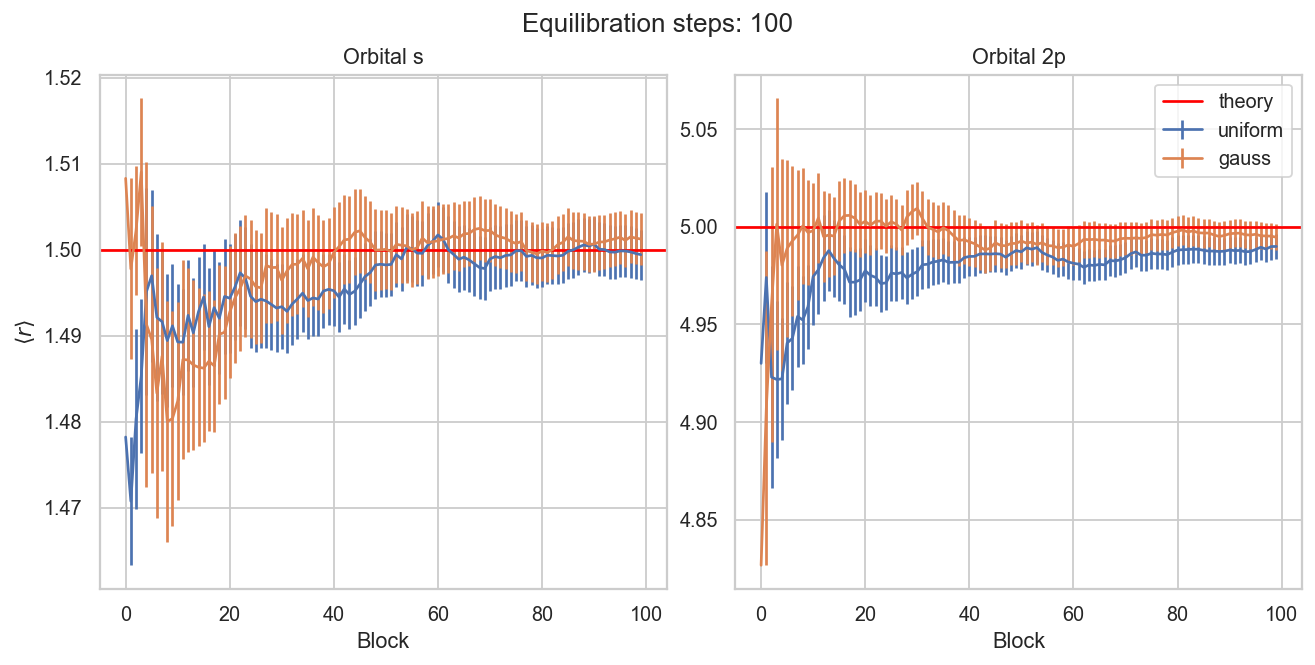

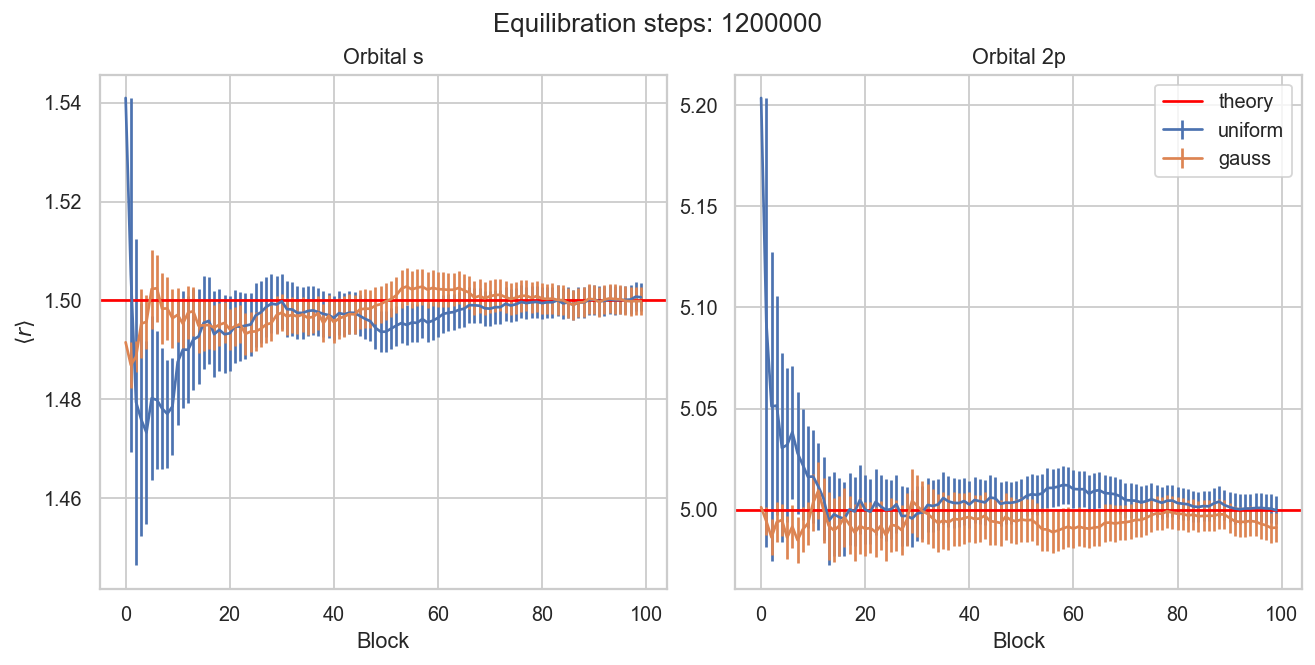

In [3]:
USE_CACHE = True
S0 = [0.0, 0.0, 0.0]
WARMUP_STEPS = 100

run(WARMUP_STEPS, S0, positions=False, use_cache=USE_CACHE)
axes = show_results(WARMUP_STEPS, S0, sharex=True, figsize=(10,5), constrained_layout=True)
axes[0].figure.suptitle(f"Equilibration steps: {WARMUP_STEPS}")

# Guessed by looking at the first row of plots
WARMUP_STEPS = N_THROWS // N_BLOCKS * 60

run(WARMUP_STEPS, S0, positions=False, use_cache=USE_CACHE)
axes = show_results(WARMUP_STEPS, S0, sharex=True, figsize=(10,5), constrained_layout=True)
axes[0].figure.suptitle(f"Equilibration steps: {WARMUP_STEPS}");

In the trial above we can see that radically increasing the equilibration time yields better results, but even using a short warmup may be acceptable. From the first couple of plots it can be seen that around the $60^\mathrm{th}$ block (hence having performed 60% of the throws) the estimation reach some kind of stabilization, so it can be used as a good equilibration time.

### Starting from high probability states

Acceptance rates:
                s        2p
uniform  0.501771  0.507081
gauss    0.504946   0.50013
Acceptance rates:
                s        2p
uniform  0.501759  0.507077
gauss    0.505625  0.500021


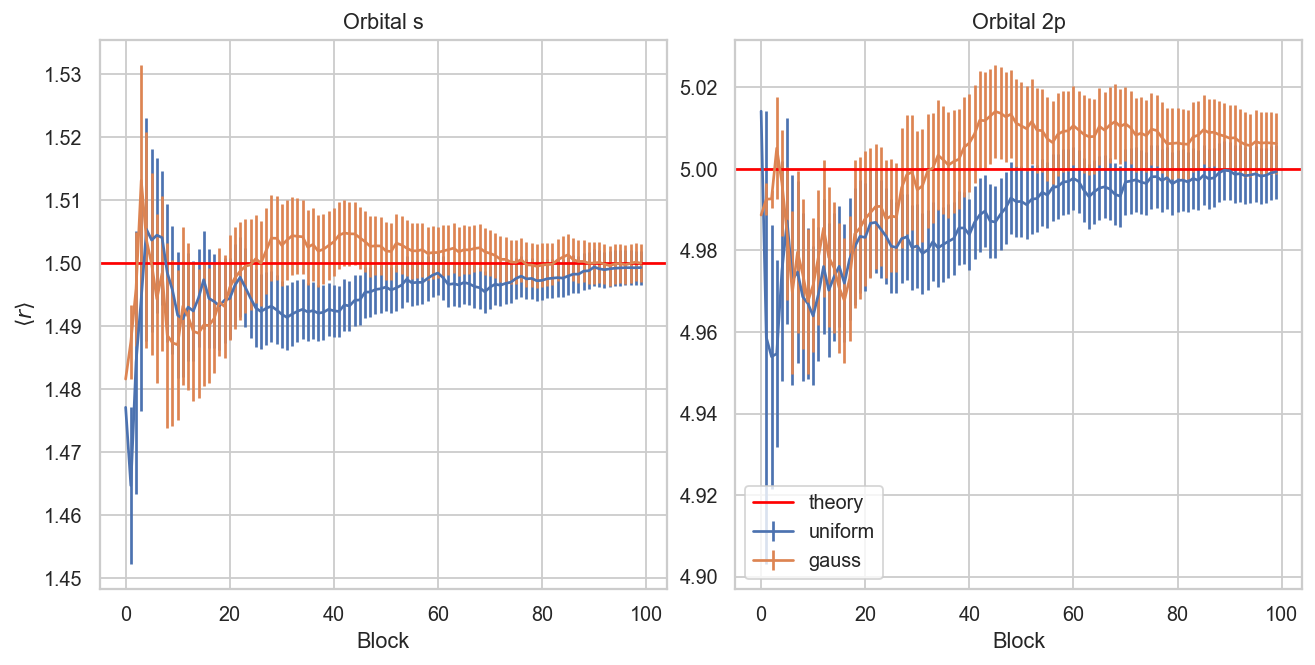

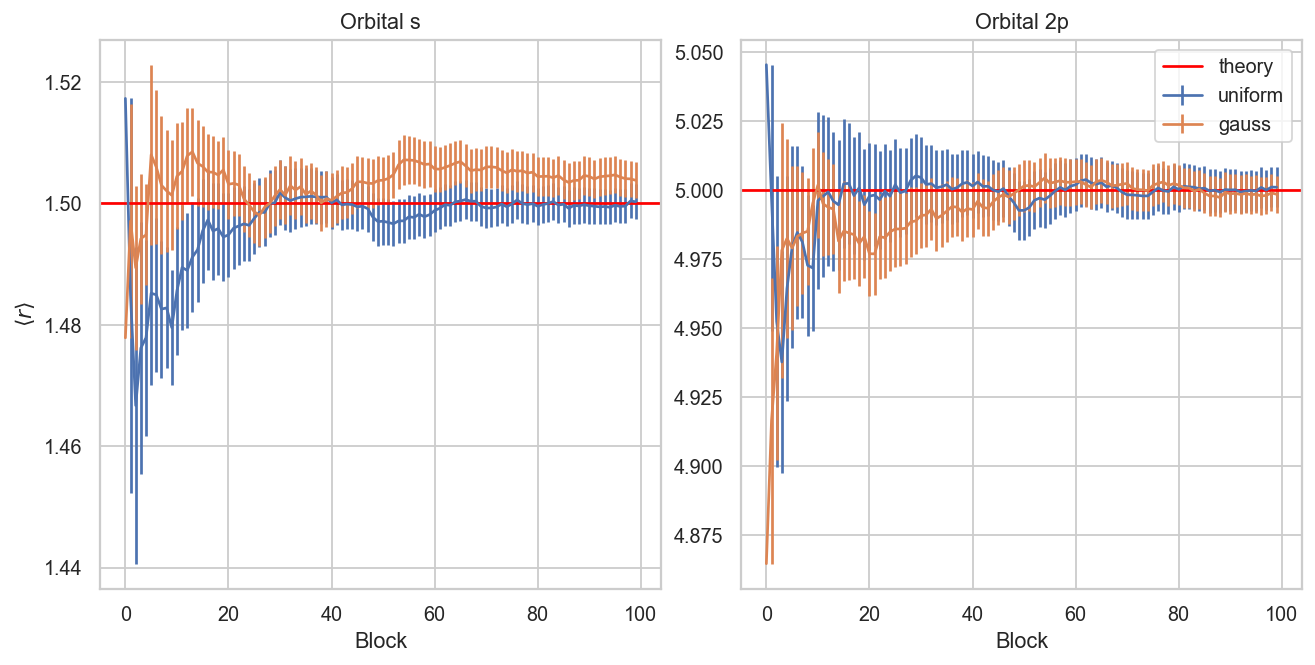

In [4]:
USE_CACHE = True
S0_s = [0., 0., 1.5]
S0_2p = [0., 0., 5.]
WARMUP_STEPS = 10

run(WARMUP_STEPS, S0_s, orbitals=["s"], positions=False, use_cache=USE_CACHE)
run(WARMUP_STEPS, S0_2p, orbitals=["2p"], positions=True,use_cache=USE_CACHE)
show_results(WARMUP_STEPS, [S0_s, S0_2p], sharex=True, figsize=(10,5), constrained_layout=True)

# Guessed by looking at the first row of plots
WARMUP_STEPS = N_THROWS // N_BLOCKS * 60

run(WARMUP_STEPS, S0_s, orbitals=["s"], positions=False, use_cache=USE_CACHE)
run(WARMUP_STEPS, S0_2p, orbitals=["2p"], positions=True,use_cache=USE_CACHE)
show_results(WARMUP_STEPS, [S0_s, S0_2p], sharex=True, figsize=(10,5), constrained_layout=True);

Even starting from a "good" site requires some equilibration.

### Starting far away

Acceptance rates:
                s        2p
uniform  0.501928   0.50642
gauss    0.504803  0.500336
Acceptance rates:
                s        2p
uniform  0.501767  0.506857
gauss    0.504293  0.499841
Acceptance rates:
                s        2p
uniform  0.502459   0.50705
gauss    0.505413  0.499725


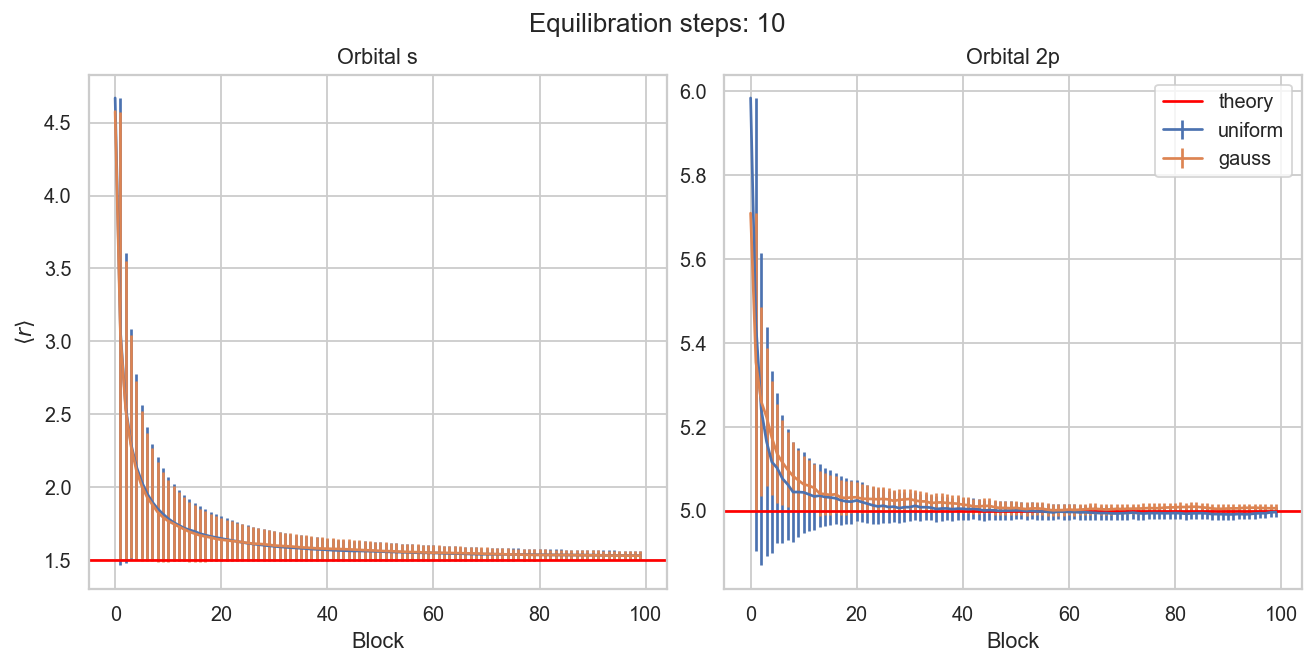

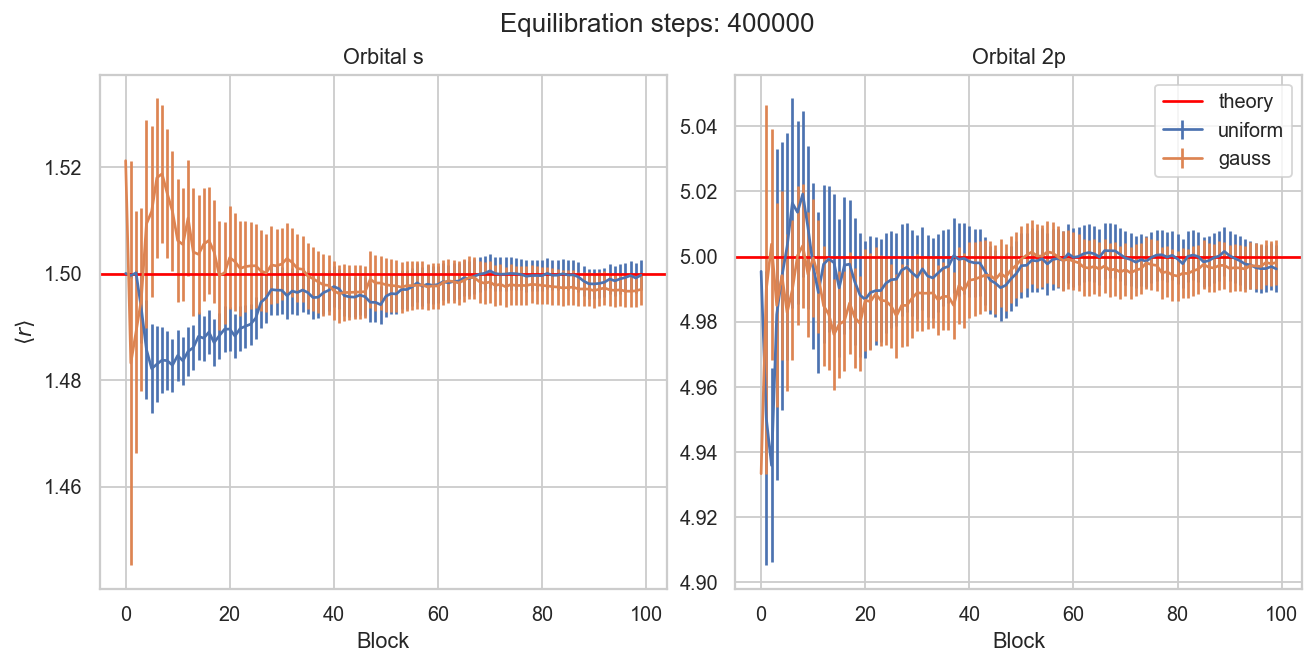

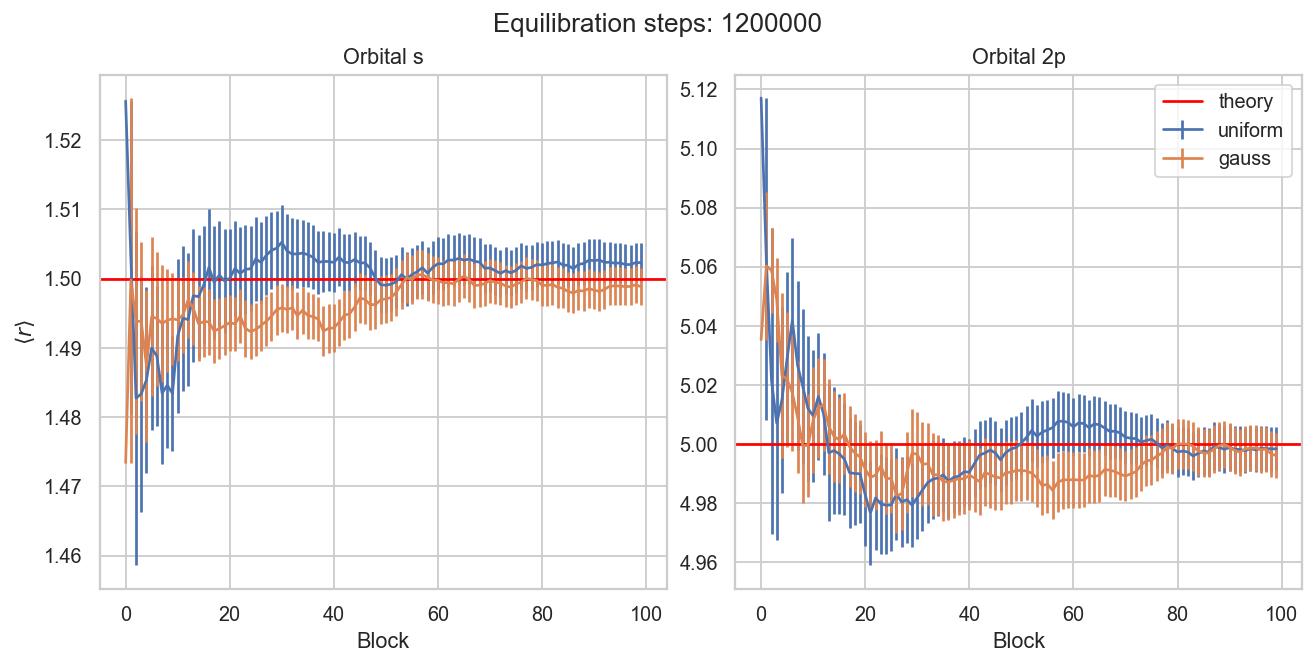

In [5]:
USE_CACHE = True
S0 = [100., 100., 100.]
WARMUP_STEPS = 10

run(WARMUP_STEPS, S0, positions=False, use_cache=USE_CACHE)
axes = show_results(WARMUP_STEPS, S0, sharex=True, figsize=(10,5), constrained_layout=True)
axes[0].figure.suptitle(f"Equilibration steps: {WARMUP_STEPS}");

WARMUP_STEPS = N_THROWS // N_BLOCKS * 20

run(WARMUP_STEPS, S0, positions=False, use_cache=USE_CACHE)
axes = show_results(WARMUP_STEPS, S0, sharex=True, figsize=(10,5), constrained_layout=True)
axes[0].figure.suptitle(f"Equilibration steps: {WARMUP_STEPS}");

WARMUP_STEPS = WARMUP_STEPS + N_THROWS // N_BLOCKS * 40

run(WARMUP_STEPS, S0, positions=False, use_cache=USE_CACHE)
axes = show_results(WARMUP_STEPS, S0, sharex=True, figsize=(10,5), constrained_layout=True)
axes[0].figure.suptitle(f"Equilibration steps: {WARMUP_STEPS}");

Even if the starting point is offset by very much, the equilibration time needed to have stable results remains the same.

From the plots above two consideration can be made:
- the step sampling strategy doesn't seem to impact much the result or the convergence time;
- the equilibration time may play an important role in providing good results. In general the chosen number of throws allows the sampling procedure to equilibrate itself;
- the blocks should be big enough to cover the chain's correlation time!

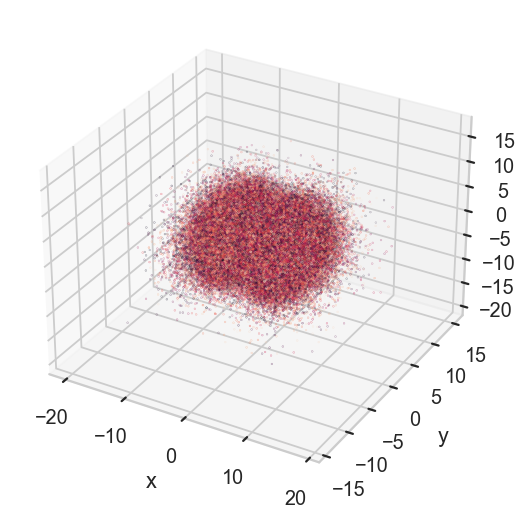

In [6]:
# Plotting an example of sampled points
plot_cloud(10, S0_2p, "2p", "uniform", 5);